In [1]:
#ライブラリのインポート
import numpy as np
import math
import werthmuller_201 as wdlf
import matplotlib.pyplot as plt
import csv
import random

In [2]:
base , j0 = wdlf.base,wdlf.j0 #フィルター

In [3]:
#設定
current = 1 #電流
PE = [300,100,300,10,10] #上限値
PED = [math.log10(x) for x in PE] #上限値の常用対数
PS = [1, 0.1,1,0.5,0.5] #下限値
PST = [math.log10(x) for x in PS] #下限値の常用対数
nTimes = 1 #回数
StopRMSPE = 0.001 #打ち切り相対誤差
nLayer = (len(PST) + 1)/2 #層の数
nGen = 200 #世代数


MP = len(PED) #染色体数
nbit = 8 #ビット数
nPop = 200 #個体数
elite = 1 #エリート数
crate = 0.8 #交叉率
q = np.zeros(nPop)
DNA1 = np.zeros((nPop,MP,nbit))
newDNA = np.zeros((nPop,MP,nbit)) #新しいDNA
eliteDNA = np.zeros((MP,nbit)) #エリート
mRate = 0.05 #突然変異率
#突然変異？

In [4]:
#ファイルの読み込み
obs = []
with open('ObsData2023.csv','r') as file:
    csv_reader = csv.reader(file)
    for row in csv_reader:
        obs.append(row)
    
    
    obs.pop(0)
    obs = [[float(x) for x in y] for y in obs]
    print(obs)


[[1.0, 98.156], [2.0, 88.855], [3.0, 74.075], [4.0, 59.012], [5.0, 46.675], [6.0, 37.79], [7.0, 31.97], [8.0, 28.51], [9.0, 26.733], [10.0, 26.102], [11.0, 26.228], [12.0, 26.837], [13.0, 27.747], [14.0, 28.836], [15.0, 30.026], [16.0, 31.266], [17.0, 32.524], [18.0, 33.779], [19.0, 35.02], [20.0, 36.239]]


In [5]:
#適応度計算の関数
def calc_fitness(fitness,nPop,nbit,DNA):
    fitness = [0] * nPop #配列の用意
    for ii in range(nPop):
        for jj in range(MP):
            fitness[ii] = sum(DNA[ii][jj]) / (nbit*MP)
    
    #print(fitness)
    return fitness

In [6]:
#エリート抽出
def pick_up_elite(fitness,DNA,eliteDNA):
    elite_number = fitness.index(max(fitness)) #エリートの位置抽出
    eliteDNA = np.zeros((MP,nbit)) #配列の用意
    for jj in range(MP):
        eliteDNA[jj][:] = DNA[elite_number][jj][:]
    return eliteDNA

In [7]:
#ルーレット盤作成の関数
def make_roulette(fitness,nPop,q):
    sumv = 0.0
    q = [0] * nPop #配列の用意
    for ii in range(nPop):
        sumv = sumv + fitness[ii]
    
    q[0] = fitness[0] / sumv
    for ii in range(nPop-1):
        q[ii+1] = q[ii] + fitness[ii+1]/sumv
    
    #print(q)
    return q

In [8]:
#ルーレットを回す関数
def spin_roulette(DNA,DNA1,q,nPop):
    ns = [0] * nPop #何行目が選ばれたかを覚えさせる配列
    DNA1 = np.zeros((nPop,MP,nbit))
    for ii in range(nPop):
        rout = random.random() #ルーレット回す
        for jj in range(nPop):
            if q[jj] > rout: #ルーレット選ばれる
                ns[ii] = jj #選ばれた場所を覚えさせる
                break
 
    for ii in range(nPop):
        for jj in range(MP):
            DNA1[ii][jj][:] = DNA[ns[ii]][jj][:] #選ばれた遺伝子

    return DNA1  

In [9]:
#1点交叉の関数
def cross1(crate,nc,nPop,DNA1,elite,eliteDNA):
    
    nc = 0 #交叉発生回数
    #nPop = 10
    ns = [100] * nPop
    newDNA = np.zeros((nPop,MP,nbit)) #新しいDNA
    for ii in range(nPop - elite):
        rrr = random.random()
        if rrr <= crate: #交叉発生
            nc = nc + 1 #交叉発生回数
            ns[nc-1] = ii #交叉発生個体番号

    if np.mod(nc, 2) == 1: #交叉回数が奇数回なら
        nc = nc + 1 #無理やり増やす
        ns[nc-1] = int(nPop*random.random()) #ランダムでどっか追加

    #print(ns,'の箇所が交差') #これの箇所が交叉する
    #print(nc,'回交叉') #これの回数交叉する

    #print('もとの遺伝子')
    #for ii in range(nPop):
    #    print(ii,DNA1[ii])
    for ii in range(int(nc/2)):
        i1 = 2 * ii 
        i2 = 2 * ii + 1
        for jj in range(MP):
            rrr = random.random()
            icpnt = int((nbit-1)*rrr) + 1#交叉点位置
            #print(icpnt,':各回の交叉点位置')
            #print(i1,i2)
            for kk in range(icpnt): #前半
                #print('前半',kk)
                newDNA[i1][jj][kk] = DNA1[ns[i1]][jj][kk]   
                newDNA[i2][jj][kk] = DNA1[ns[i2]][jj][kk]
            for kk in range(nbit-icpnt):
                #print('後半',kk+icpnt) #後半
                newDNA[i1][jj][kk+icpnt] = DNA1[ns[i2]][jj][kk+icpnt]
                newDNA[i2][jj][kk+icpnt] = DNA1[ns[i1]][jj][kk+icpnt]
        #print(newDNA)


    for ii in range(nc):
        for jj in range(MP):
            DNA1[ns[ii]][jj][:] = newDNA[ii][jj][:] #更新
    
    #print('あとの遺伝子')
    #for ii in range(nPop):
    #    print(ii,DNA1[ii])
    
    for jj in range(MP):
        DNA1[nPop-1][jj][:] = eliteDNA[jj][:] #エリートの追加
    
    return DNA1

In [10]:
#突然変異
def mttn1(DNA,MP,nPop,mRate):
    for ii in range(nPop-1):
        for jj in range(MP):
            for kk in range(nbit):
                if (random.random() < mRate):
                    if (DNA[ii][jj][kk] == 1):
                        DNA[ii][jj][kk] = 0
                    else:
                        DNA[ii][jj][kk] = 1
    return DNA
                        

In [11]:
#一様交叉
def crossu(crate,nc,nPop,DNA1,elite,eliteDNA):
    
    nc = 0 #交叉発生回数
    #nPop = 10
    ns = [100] * nPop
    mDNA = [100] * nbit
    
    newDNA = np.zeros((nPop,MP,nbit)) #新しいDNA
    for ii in range(nPop - elite):
        rrr = random.random()
        if rrr <= crate: #交叉発生
            nc = nc + 1 #交叉発生回数
            ns[nc-1] = ii #交叉発生個体番号

    if np.mod(nc, 2) == 1: #交叉回数が奇数の時
        nc = nc + 1 #無理やり追加
        ns[nc-1] = int(nPop*random.random()) #ランダムで追加
        
    #print(ns,'の箇所が交差') #これの箇所が交叉する
    #print(nc,'回交叉') #これの回数交叉する

    #print('もとの遺伝子')
    #for ii in range(nPop):
    #    print(ii,DNA1[ii])

    for ii in range(int(nc/2)):
        i1 = 2 * ii  
        i2 = 2 * ii + 1
        for jj in range(MP): #ランダムでマスクDNAの作成
            for kk in range(nbit):
                mDNA[kk] = random.random()
                if mDNA[kk] > 0.5:
                    mDNA[kk] = 1
                else:
                    mDNA[kk] = 0
                
            crossINDEX = [i for i, x in enumerate(mDNA) if x == 1] #マスクDNAの1の位置の抽出
            size = len(crossINDEX) #そのサイズ
            #print(crossINDEX)

            for kk in range(nbit): #一旦全部の引継ぎ
                newDNA[i1][jj][kk] = DNA1[ns[i1]][jj][kk]   
                newDNA[i2][jj][kk] = DNA1[ns[i2]][jj][kk]
        
            for kk in range(size): #入れ替える箇所は入れ替え
                newDNA[i1][jj][crossINDEX[kk]] = DNA1[ns[i2]][jj][crossINDEX[kk]]
                newDNA[i2][jj][crossINDEX[kk]] = DNA1[ns[i1]][jj][crossINDEX[kk]]
        
    
    for ii in range(nc):
        for jj in range(MP):
            DNA1[ns[ii]][jj][:] = newDNA[ii][jj][:] #更新
        #print(ns[ii])
    #print('あとの遺伝子')
    #for ii in range(nPop):
    #    print(ii,DNA1[ii])
    for jj in range(MP):
        DNA1[nPop-1][jj][:] = eliteDNA[jj][:] #エリートの追加
    
    
    return DNA1

In [12]:
#2進数から10進数
def b2d(MP,nPop,DNA):
    n10 = np.zeros((nPop,MP))
    for ii in range(nbit):
        for jj in range(MP):
            for kk in range(nPop):
                n10[kk][jj] = n10[kk][jj] + DNA[kk][jj][nbit-1-ii]*2**ii

    return n10

In [13]:
#上限と下限に収める
def getxi(nbit,MP,nPop,PST,PED,n10):
    x1 = np.zeros((nPop,MP))
    for ii in range(nPop):
        for jj in range(MP):
            x1[ii][jj] = PST[jj] + n10[ii][jj]*(PED[jj]-PST[jj])/(2**nbit-1)
    return x1


In [14]:
#順解析
def calc_phi(base,j0,a,resistivity,current,thickness):
    T = np.zeros((len(base),len(resistivity))) #核関数Tの用意、大きさはフィルターの数×層の数
    T[:,-1]= resistivity[-1] #最後の層の核関数に比抵抗を代入
    rx = np.array([a,a*2.0]) #電極間隔について(とりあえず今は1mのとき)
    phi = np.zeros(len(rx)) #電位の用意
    lamda = np.zeros(len(base)) #ラムダについて、フィルターの数分
    bns = np.zeros(len(base))
    bnb = np.zeros(len(base))
    #外側ループ(rxの数だけ)
    phi = np.zeros(len(rx))
    for ii in range(len(rx)):
        lamda[:] = base[:]/rx[ii]
        for kk in range(len(resistivity)-2,-1,-1): #層ごとのループ
            bns[:] = T[:,kk+1]+resistivity[kk]*np.tanh(lamda[:]*thickness[kk])
            bnb[:] = 1.0 + T[:,kk+1]*np.tanh(lamda[:]*thickness[kk])/resistivity[kk]
            T[:,kk] = bns[:]/bnb[:]
           
        for jj in range(len(base)):
            phi[ii] = phi[ii] + current*T[jj,0]*j0[jj]/(2.0*math.pi*rx[ii])

    return phi

In [15]:
#順解析
def dc1dwenner(a,base,j0,resistivity,thickness,current):
    resis = np.zeros(len(a))
    V = np.zeros(len(a))
    appres = np.zeros(len(a))
    for ii in range(len(a)):
        phi =  calc_phi(base,j0,a[ii],resistivity,current,thickness)
        c1p1 = phi[0]
        c1p2 = phi[1]
        c2p1 = phi[1]
        c2p2 = phi[0]
        V1 = c1p1 - c2p1
        V2 = c1p2 - c2p2
        V[ii] = abs(V1 - V2) #電位
        resis[ii] = V[ii] / current 
        appres[ii] = 2 * math.pi * a[ii] * resis[ii] #見掛比抵抗
        #print(V[ii],appres[ii])
    return appres

In [16]:
#観測値の読み込み(対数)
obsData = np.zeros(len(obs))
a = np.zeros(len(obs))
for ii in range(len(obs)):
    a[ii] = obs[ii][0]
    obsData[ii] = math.log10(obs[ii][1])

#初期集団の生成
DNA = np.zeros((nPop,MP,nbit)) #DNA
#ループでランダム作成
for ii in range(nbit):
    for jj in range(MP):
        for kk in range(nPop):
            DNA[kk][jj][ii] = random.random() #乱数を代入
            if DNA[kk][jj][ii] > 0.5: 
                DNA[kk][jj][ii] = int(1) #0.5より大きいと1
            else:
                DNA[kk][jj][ii] = int(0) #それ以外は0
n10 = b2d(MP,nPop,DNA)
x1 = 10**getxi(nbit,MP,nPop,PST,PED,n10)

resistivity = np.zeros((nPop,int(nLayer)))
thickness = np.zeros((nPop,len(PST)-int(nLayer)))
V = np.zeros((nPop,len(a)))
appres = np.zeros((nPop,len(a)))
fitness = [0]*nPop


#第一世代の計算
for ii in range(nPop):
    for jj in range(int(nLayer)):
        resistivity[ii][jj] = x1[ii][jj]
    for jj in range(len(PST)-int(nLayer)):
        thickness[ii][jj] = x1[ii][jj+int(nLayer)]
    appres[ii][:] = dc1dwenner(a,base,j0,resistivity[ii][:],thickness[ii][:],current)
    fit = 0
    for jj in range(len(a)):
        fit = fit + (math.log10(appres[ii][jj]) - obsData[jj])**2.0
    fitness[ii] = nPop/fit

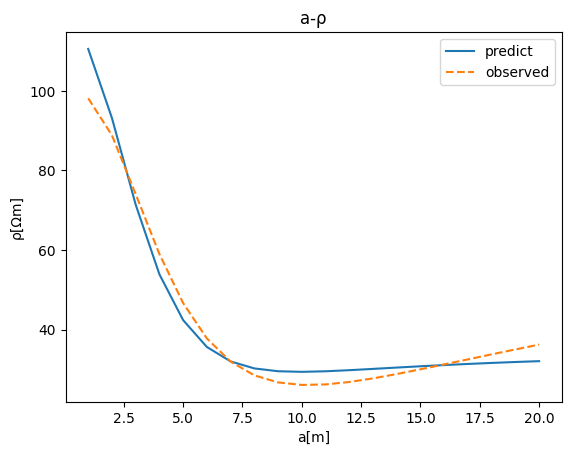

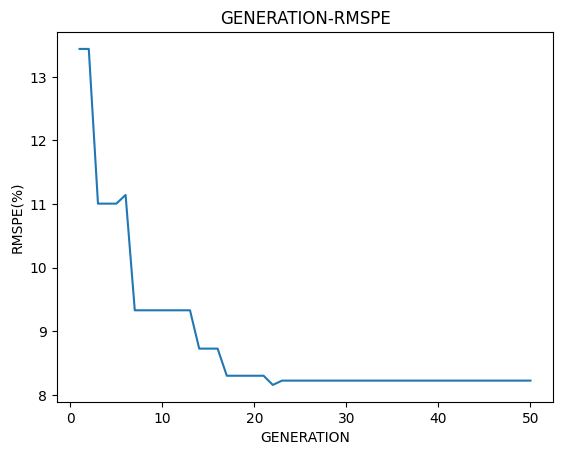

In [17]:
RR = []
num = []
for ll in range(50):
    q = make_roulette(fitness,nPop,q) #ルーレット盤の作成
    DNA1 = spin_roulette(DNA,DNA1,q,nPop) #ルーレット回す
    nc = 0
    eliteDNA = pick_up_elite(fitness,DNA,eliteDNA) #エリートの選定
    DNA = mttn1(DNA,MP,nPop,mRate)
    #DNA = cross1(crate,nc,nPop,DNA1,elite,eliteDNA) #1点交叉
    DNA = crossu(crate,nc,nPop,DNA1,elite,eliteDNA) #一様交叉
    n10 = b2d(MP,nPop,DNA) #10進数に
    x1 = 10**getxi(nbit,MP,nPop,PST,PED,n10)
    #第ll世代の計算
    for ii in range(nPop):
        for jj in range(int(nLayer)):
            resistivity[ii][jj] = x1[ii][jj]
        for jj in range(len(PST)-int(nLayer)):
            thickness[ii][jj] = x1[ii][jj+int(nLayer)]
        appres[ii][:] = dc1dwenner(a,base,j0,resistivity[ii][:],thickness[ii][:],current)
        fit = 0
        for jj in range(len(a)):
            fit = fit + (math.log10(appres[ii][jj]) - obsData[jj])**2.0
        fitness[ii] = nPop/fit
        #print(resistivity[ii][:],thickness[ii][:])
    max_index = fitness.index(max(fitness)) #最大適応値の抽出
    #va = np.var(fitness)
    #print(appres[1][:])
    #print(fitness[max_index])
    
    num.append(ll+1)
    RMSPE = 0
    for ii in range(len(obs)):
        RMSPE = RMSPE + ((appres[max_index][ii] - 10**obsData[ii]) / 10**obsData[ii])**2
    RMSPE = (RMSPE/len(obs))**0.5 * 100
    RR.append(RMSPE)
    #print(RMSPE,resistivity[max_index][:],thickness[max_index][:])
    
#print(appres[max_index][:])        
plt.plot(a, appres[max_index][:], label='predict')
plt.plot(a, 10**obsData, '--',label='observed')
# グラフのタイトルと軸ラベル
plt.title('a-ρ')
plt.xlabel('a[m]')
plt.ylabel('ρ[Ωm]')

# 凡例の表示
plt.legend()

# 図の表示
plt.show()


plt.plot(num,RR)
plt.title('GENERATION-RMSPE')
plt.xlabel('GENERATION')
plt.ylabel('RMSPE(%)')
plt.show()



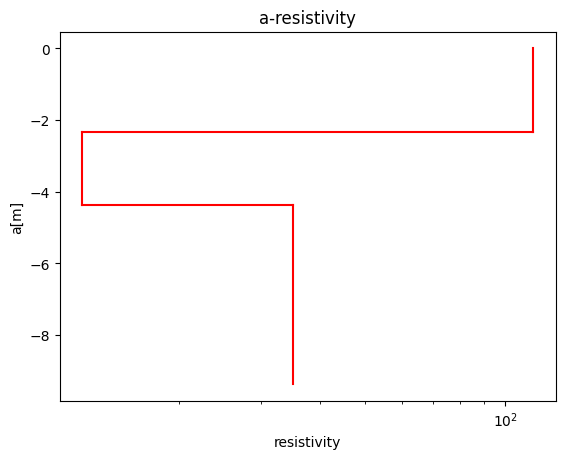

In [18]:
#最終地下構造

x1 = [resistivity[max_index][0],resistivity[max_index][0]]
y1 = [0,-thickness[max_index][0]]
x2 = [resistivity[max_index][0],resistivity[max_index][1]]
y2 = [-thickness[max_index][0],-thickness[max_index][0]]
x3 = [resistivity[max_index][1],resistivity[max_index][2]]
y3 = [-thickness[max_index][0]-thickness[max_index][1],-thickness[max_index][0]-thickness[max_index][1]]
x4 = [resistivity[max_index][1],resistivity[max_index][1]]
y4 = [-thickness[max_index][0],-thickness[max_index][0]-thickness[max_index][1]]
x5 = [resistivity[max_index][2],resistivity[max_index][2]]
y5 = [-thickness[max_index][0]-thickness[max_index][1],-thickness[max_index][0]-thickness[max_index][1]-5]

plt.plot(x1,y1,color='red')
plt.plot(x2,y2,color='red')
plt.plot(x3,y3,color='red')
plt.plot(x4,y4,color='red')
plt.plot(x5,y5,color='red')
plt.xscale('log')

# グラフのタイトルと軸ラベル
plt.title('a-resistivity')
plt.xlabel('resistivity')
plt.ylabel('a[m]')
plt.show()




初めの方の世代数の時は、RMSPEの減少は大きいが、徐々に小さくなる。また、後の方の世代でRMSPEが一気に減少する時は、突然変異が良い方向に働いたと考えられる。